## Metadata and Annotations: Cleaning and Preprocessing

**Author**: Calvin Chan

**Data**: PTB-XL (https://physionet.org/content/ptb-xl/1.0.3/)

### Introduction
In this notebook we will go through the cleaning and preprocessing of our two additional CSV files `ptbxl_database.csv` and `scp_statements.csv`. These files contain patient information that go along with each ECG signal as well its diagnostic superclass (ECG  diagnosis) which we will be using for our project. Below we show the five types of ECG classification.

**Diagnostic Classes**

In general, ECG signals can show many conditions, however, for our simplicity we will categorize them into larger groups called superclasses. This is readily done in our dataset PTB-XL where they categorized different conditions into five diagnostic superclasses:

| # Records | Superclass | Description            | Common Name                      |
|-----------|------------|------------------------|--------------------------------- |
| 9514      | NORM       | Normal ECG             | Normal                           |
| 5469      | MI         | Myocardial Infarction  | Heart Attack                     |
| 5235      | STTC       | ST/T Change            | Changes in ST Segment and T Wave |
| 4898      | CD         | Conduction Disturbance | Heart Blocks                     |
| 2649      | HYP        | Hypertrophy            | Enlarged Cardiac Muscles         |

> **Note**: The sum of the number of records here is more than the number of rows in the data because some ECG recordings show more than one condition.

### Procedures
1. Import diagnostics from annotation (`scp_statements.csv`) to metadata (`ptbxl_database.csv`)
    - Use `scp_code` column in metadata to get the diagnostic superclass
2. Clean metadata (can be done simultaneously with step 3)
    - Metadata `NaN` values
        - if rows dropped, need to drop corresponding signal too
3. Clean signals
    - Denoise using Fourier Transforms 
        - Removing higher frequencies by taking samples from each superclass and stacking them on top of each other
4. EDA 
    - Checking to see if there are any noticeable patterns for each diagnostic superclass

### Table of Contents
- [Annotations](#annotations)
- [Metadata](#metadata)

### Questions (for myself)
- Only consider highest likelihood diagnostic superclass for each signal?


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import ast

%autosave 300

Autosaving every 300 seconds


<a id='annotations'></a>
### Annotations

For this section, we will look at the `scp_statements.csv` file which contains a list of statements called **Standard Communications Protocol for Computer Assisted Electrocardiography** (SCP-ECG). These are a set of standard formats for storing ECG data, metadata and annotations universally. In our metadata file (`ptbxl_database.csv`) we have a column that contains SCP codes, which is where we will extract the diagnosis of the corresponding ECG from using the list of statements. 

**Note**: Some of the following code blocks in this section were taken from `example_physionet.py` included in the data set and can be found [here](https://physionet.org/content/ptb-xl/1.0.3/example_physionet.py). 

Let's look at the SCP codes in our metadata file first:

In [29]:
# Load metadata file
path = '../data/physionet.org/files/ptb-xl/1.0.3/'

metadata = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

In [30]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  infarc

Since we have a lot of columns, by default Pandas would not show all of them. However, we can temporarily make it show all using the following code from [this](https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe) website.

In [4]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Metadata head:")
    display(metadata.head())
    print("Metadata tail:")
    display(metadata.tail())

Metadata head:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Metadata tail:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,"{'NORM': 100.0, 'SR': 0.0}",LAD,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
21837,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,"{'NORM': 100.0, 'SR': 0.0}",MID,NaN,NaN,1.0,False,True,True,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr


Let's focus on the `scp_codes` column and see how the values are interpreted by Pandas. 

In [5]:
metadata['scp_codes'].iloc[0]

"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"

We see that Pandas interprets the dictionaries in `scp_codes` as literal strings. This can by updated by applying the `literal_eval()` function from the `ast` library.

In [6]:
# Pandas probably read the scp_codes as strings, we can change them to be interpreted as dictionaries with ast
metadata['scp_codes'] = metadata['scp_codes'].apply(lambda x: ast.literal_eval(x)) 

In [7]:
metadata['scp_codes'].iloc[0]

{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

Now we see that the string got turned back into a dictionary and so we can use this column to tell us the diagnostic superclass for each ECG.

Let's load our annotation file now and see the kinds of SCP statements we have. 

In [31]:
annot = pd.read_csv(path + 'scp_statements.csv', index_col=0)

In [32]:
annot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, NDT to TRIGU
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   description                    71 non-null     object 
 1   diagnostic                     44 non-null     float64
 2   form                           19 non-null     float64
 3   rhythm                         12 non-null     float64
 4   diagnostic_class               44 non-null     object 
 5   diagnostic_subclass            44 non-null     object 
 6   Statement Category             71 non-null     object 
 7   SCP-ECG Statement Description  71 non-null     object 
 8   AHA code                       37 non-null     float64
 9   aECG REFID                     23 non-null     object 
 10  CDISC Code                     13 non-null     object 
 11  DICOM Code                     13 non-null     object 
dtypes: float64(4), object(8)
memory usage: 7.2+ KB


In [33]:
# Head and tail of data
print("Annotation head:")
display(annot.head())
print("Annotation tail:")
display(annot.tail())

Annotation head:


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


Annotation tail:


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
BIGU,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,1.0,NaN,NaN,Statements related to ectopic rhythm abnormali...,"bigeminal pattern (unknown origin, SV or Ventr...",NaN,NaN,NaN,NaN
AFLT,atrial flutter,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,atrial flutter,51.0,MDC_ECG_RHY_ATR_FLUT,NaN,NaN
SVTAC,supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,supraventricular tachycardia,55.0,MDC_ECG_RHY_SV_TACHY,NaN,D3-31290
PSVT,paroxysmal supraventricular tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,paroxysmal supraventricular tachycardia,NaN,MDC_ECG_RHY_SV_TACHY_PAROX,NaN,NaN
TRIGU,"trigeminal pattern (unknown origin, SV or Vent...",NaN,NaN,1.0,NaN,NaN,Statements related to ectopic rhythm abnormali...,"trigeminal pattern (unknown origin, SV or Vent...",NaN,NaN,NaN,NaN


Looking deeper into the columns, we will actually find that `diagnostic` tells us which of these SCP statements are present in our metadata. Statements that are in our metadata are given a `1.0`, otherwise a `NaN`.

We can then shorten the number of rows in `annot` to make our cleaning easier. 

In [34]:
annot = annot[annot['diagnostic'] == 1.0]

In [35]:
annot.shape

(44, 12)

From here, we see that our number of rows reduced to 44 from 71.

Using this new dataframe we can now scan through `metadata`, look at the dictionary keys in `scp_codes` and match with the corresponding index in `annot` which will allow us to extract the diagnostic superclass contained in the column `diagnostic_class`.

In [36]:
def get_diagnostic(scp_code, annotation):
    diag_list = []
    for key in scp_code.keys():
        
        if key in annotation.index:
            diagnosis = annotation.loc[key]['diagnostic_class']
            diag_list.append(diagnosis)
    return sorted(set(diag_list))

In [37]:
metadata['diagnostic_superclass'] = metadata['scp_codes'].apply(lambda x: get_diagnostic(x, annot))

In [38]:
metadata['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[HYP, STTC]             781
[MI, STTC]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[CD, NORM]              407
[HYP, MI, STTC]         361
[CD, HYP]               300
[CD, MI, STTC]          223
[CD, HYP, STTC]         211
[HYP, MI]               183
[CD, HYP, MI, STTC]     156
[CD, HYP, MI]           117
[NORM, STTC]             28
[CD, NORM, STTC]          5
[CD, HYP, NORM]           2
[HYP, NORM]               2
[CD, HYP, MI, NORM]       1
Name: count, dtype: int64

<a id='metadata'></a>
### Metadata

In this section we will clean our metadata file.

**Data Dictionary**
- patient_id : Unique to each patient (some patients can have more than one ECG though)
- age : Patient age
- sex : Male = `0`, Female = `1`
- height : Patient height in cm
- weight : 
- nurse
- site
- device
- recording_date
- report
- scp_codes
- heart_axis
- infarction_stadium1
- infarction_stadium2
- validated_by
- second_opinion
- initial_autogenerated_report
- validated_by_human
- baseline_drift
- static_noise
- burst_noise
- electrodes_problems
- extra_beats
- pacemaker
- strat_fold
- filename_lr
- filename_hr

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
metadata = pd.read_csv('../data/physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv')
metadata = metadata.set_index('ecg_id')

In [ ]:
metadata.info()

In [16]:
# Temporarily show all columns using Pandas
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(metadata.head())
    display(metadata.tail())

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]
21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,"{'NORM': 100.0, 'SR': 0.0}",LAD,NaN,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,[NORM]
21837,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,"{'NORM': 100.0, 'SR': 0.0}",MID,NaN,NaN,1.0,False,True,True,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr,[NORM]


### Data Cleaning

Let's look at the data column by column to identify Nulls and see what we can do with them. 

**Patient ID**

In [18]:
# Null values
metadata['patient_id'].isna().sum()

0

In [19]:
# Unique ids
metadata['patient_id'].value_counts()

patient_id
9898.0     10
10107.0     9
8304.0      9
17542.0     9
8810.0      8
           ..
12993.0     1
17525.0     1
14740.0     1
20297.0     1
11744.0     1
Name: count, Length: 18869, dtype: int64

We see that in `patient_id` there is a total of **21837 rows but only 18869 are unique** (i.e. there are only 18869 patients).

**Age**

In [20]:
# Null values
metadata['age'].isna().sum()

0

In [21]:
# Unique age groups
metadata['age'].value_counts()

age
67.0    558
68.0    553
65.0    551
66.0    537
54.0    530
       ... 
9.0       2
12.0      2
2.0       1
6.0       1
7.0       1
Name: count, Length: 89, dtype: int64

We also see that `age` does **not** contain any Null values and has **89 unique ages**.

**Sex**
- Male: `0`
- Female: `1`

In [22]:
# Null values
metadata['sex'].isna().sum()

0

In [23]:
# Distribution
metadata['sex'].value_counts()

sex
0    11354
1    10445
Name: count, dtype: int64

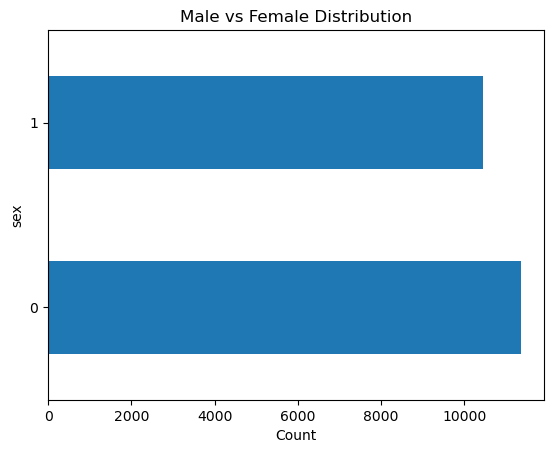

In [24]:
metadata['sex'].value_counts().plot(kind='barh')
plt.title('Male vs Female Distribution')
plt.xlabel('Count')
plt.show()

Again we can see that there are no Null values in the column `sex`.

**Height**

In [25]:
metadata['height'].isna().sum()

14825

In [26]:
# Male vs Female Height Distribution
metadata.groupby('sex')['height'].mean()

sex
0    173.491999
1    160.988381
Name: height, dtype: float64

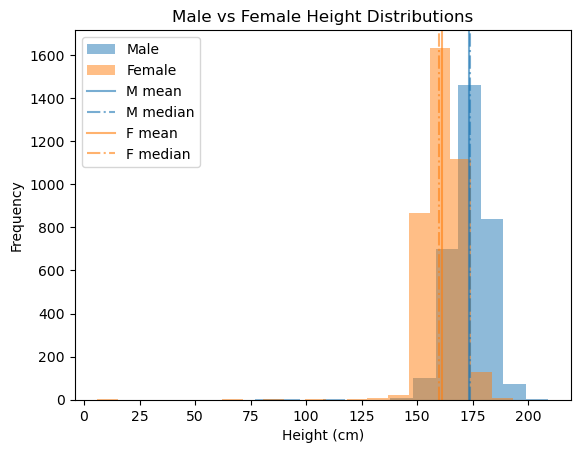

In [27]:
metadata.groupby('sex')['height'].plot(kind='hist', bins=20, alpha=0.5)
plt.axvline(metadata.groupby('sex')['height'].mean()[0], c='C0', alpha=0.6)
plt.axvline(metadata.groupby('sex')['height'].median()[0], c='C0', ls='-.', alpha=0.6)
plt.axvline(metadata.groupby('sex')['height'].mean()[1], c='C1', alpha=0.6)
plt.axvline(metadata.groupby('sex')['height'].median()[1], c='C1', ls='-.', alpha=0.6)
plt.title("Male vs Female Height Distributions")
plt.xlabel("Height (cm)")
plt.legend(['Male', 'Female', 'M mean', 'M median', 'F mean', 'F median'])
plt.show()

In [28]:
metadata['height'].plot(kind='hist', bins=20)
plt.title("Height Distribution of Patients")
plt.axvline(metadata['height'==])
plt.xlabel("Height (cm)")
plt.show()

SyntaxError: invalid syntax (3391632906.py, line 3)

**Weight**

In [44]:
metadata['weight'].value_counts()

weight
70.0     579
60.0     413
80.0     375
65.0     333
63.0     321
        ... 
210.0      1
163.0      1
140.0      1
165.0      1
131.0      1
Name: count, Length: 127, dtype: int64